In [1]:
!mkdir /.kaggle
!mv kaggle.json /.kaggle
!mv /.kaggle /root/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [1]:
!kaggle datasets download -d aneeshtickoo/indian-trucks
!kaggle datasets download -d kshitij192/cars-image-dataset

Dataset URL: https://www.kaggle.com/datasets/aneeshtickoo/indian-trucks
License(s): CC0-1.0
 97% 128M/132M [00:04<00:00, 39.0MB/s]
100% 132M/132M [00:04<00:00, 28.3MB/s]
Dataset URL: https://www.kaggle.com/datasets/kshitij192/cars-image-dataset
License(s): GPL-2.0
 88% 32.0M/36.3M [00:01<00:00, 36.0MB/s]
100% 36.3M/36.3M [00:01<00:00, 25.3MB/s]


In [2]:
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 3.7 MB/s eta 0:00:00


In [3]:
import patoolib
patoolib.extract_archive("/content/cars-image-dataset.zip")
patoolib.extract_archive("/content/indian-trucks.zip")

INFO patool: Extracting /content/cars-image-dataset.zip ...
INFO:patool:Extracting /content/cars-image-dataset.zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_jgrbzwwc -- /content/cars-image-dataset.zip
INFO:patool:running /usr/bin/7z x -o./Unpack_jgrbzwwc -- /content/cars-image-dataset.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/cars-image-dataset.zip extracted to `Cars Dataset'.
INFO:patool:... /content/cars-image-dataset.zip extracted to `Cars Dataset'.
INFO patool: Extracting /content/indian-trucks.zip ...
INFO:patool:Extracting /content/indian-trucks.zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_0a2bimt1 -- /content/indian-trucks.zip
INFO:patool:running /usr/bin/7z x -o./Unpack_0a2bimt1 -- /content/indian-trucks.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/indian-trucks.zip extracted to `indian-trucks' (multiple files in root).
INFO:patool:... /content/indian-trucks.zip extra

'indian-trucks'

In [4]:
import os
import shutil

train_dir = 'Cars Dataset/train'
test_dir = 'Cars Dataset/test'
target_dir = 'cars'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

def move_images(source_dir, target_dir):
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                source_path = os.path.join(root, file)
                target_path = os.path.join(target_dir, file)
                shutil.move(source_path, target_path)

move_images(train_dir, target_dir)
move_images(test_dir, target_dir)

In [5]:
import os
import random
import shutil

def get_image_filenames(directory):
    return [
        file for file in os.listdir(directory)
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'))
    ]

def copy_random_images(source_dir, target_dir, count):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    files = get_image_filenames(source_dir)
    if len(files) < count:
        raise ValueError(f"Not enough images in {source_dir}. It contains only {len(files)} images.")

    selected_files = random.sample(files, count)
    for file in selected_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(target_dir, file))

source_dir1 = '/content/cars'
source_dir2 = '/content/indian-trucks'
target_dir1 = '/content/Dataset/cars'
target_dir2 = '/content/Dataset/trucks'
image_count = 450

copy_random_images(source_dir1, target_dir1, image_count)
copy_random_images(source_dir2, target_dir2, image_count)

print(f"Copied {image_count} random images from each directory to the new directories.")

Copied 450 random images from each directory to the new directories.


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np


In [7]:
def safe_flow_from_directory(datagen, directory, *args, **kwargs):
    gen = datagen.flow_from_directory(directory, *args, **kwargs)
    while True:
        try:
            yield next(gen)
        except Exception as e:
            print(f"Skipping a corrupted file: {e}")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = safe_flow_from_directory(
    train_datagen,
    '/content/Dataset',
    target_size = (150, 150),
    batch_size = 42,
    class_mode = 'binary',
    subset = 'training'
)



In [8]:
validation_generator = safe_flow_from_directory(
    validation_datagen,
    '/content/Dataset',
    target_size=(150, 150),
    batch_size=42,
    class_mode='binary',
    subset='validation',
)


In [9]:
model = Sequential(
    [
        Conv2D(filters=32, kernel_size= (3,3), activation = 'relu', input_shape=(150,150,3)),
        MaxPooling2D(pool_size=(3,3)),

        Conv2D(filters= 64, kernel_size= (3,3), activation= 'relu'),
        MaxPooling2D(pool_size=(3,3)),

        Conv2D(filters=128, kernel_size= (3,3), activation= 'relu'),
        MaxPooling2D(pool_size=(3,3)),

        Flatten(),
        Dense(512, activation ='relu'),
        Dropout(0.2),
        Dense(1, activation= 'sigmoid', )
    ]
)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
import os

def count_samples(directory):
    total_count = 0
    for subdir, _, files in os.walk(directory):
        total_count += len(files)
    return total_count

train_samples = count_samples('/content/Dataset/cars') + count_samples('/content/Dataset/trucks')
validation_samples = int(train_samples * 0.2)
train_samples = train_samples - validation_samples

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
batch_size = 42
steps_per_epoch = train_samples // batch_size
validation_steps = validation_samples // batch_size

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=40,
    callbacks = [early_stopping]
)

Found 720 images belonging to 2 classes.
Epoch 1/40
17/17 [==============================] - 18s 608ms/step - loss: 0.7689 - accuracy: 0.4510 - val_loss: 0.6874 - val_accuracy: 0.4940
Epoch 2/40
17/17 [==============================] - 10s 556ms/step - loss: 0.6714 - accuracy: 0.5782 - val_loss: 0.5637 - val_accuracy: 0.8214
Epoch 3/40
17/17 [==============================] - 10s 651ms/step - loss: 0.5305 - accuracy: 0.7522 - val_loss: 0.3841 - val_accuracy: 0.8393
Epoch 4/40
17/17 [==============================] - 11s 687ms/step - loss: 0.4513 - accuracy: 0.7935 - val_loss: 0.2637 - val_accuracy: 0.9167
Epoch 5/40
17/17 [==============================] - 7s 456ms/step - loss: 0.4787 - accuracy: 0.7670 - val_loss: 0.2585 - val_accuracy: 0.9226
Epoch 6/40
17/17 [==============================] - 10s 643ms/step - loss: 0.4491 - accuracy: 0.7876 - val_loss: 0.4750 - val_accuracy: 0.7262
Epoch 7/40
17/17 [==============================] - 11s 693ms/step - loss: 0.3956 - accuracy: 0.8319 -

In [12]:
print(history.history)

{'loss': [0.7689488530158997, 0.6714421510696411, 0.5304903984069824, 0.4513486325740814, 0.47872984409332275, 0.4490789771080017, 0.39558568596839905, 0.3396633565425873, 0.3447471857070923, 0.3170555531978607, 0.3328481912612915, 0.28101855516433716, 0.27047964930534363, 0.30792826414108276, 0.28281331062316895, 0.29050901532173157, 0.25241902470588684], 'accuracy': [0.45098039507865906, 0.5781710743904114, 0.752212405204773, 0.7935103178024292, 0.7669616341590881, 0.7876105904579163, 0.8318583965301514, 0.8495575189590454, 0.8687315583229065, 0.8716813921928406, 0.8598819971084595, 0.8879055976867676, 0.8967551589012146, 0.8716813921928406, 0.8879055976867676, 0.8775811195373535, 0.9100294709205627], 'val_loss': [0.6874150633811951, 0.5636938810348511, 0.384121835231781, 0.26374000310897827, 0.2585306465625763, 0.47504839301109314, 0.21991664171218872, 0.2124638855457306, 0.33384478092193604, 0.17955128848552704, 0.1897975653409958, 0.12872372567653656, 0.2862370014190674, 0.1302384

500/500 [==============================] - 164s 328ms/step - loss: 0.1347 - accuracy: 0.9331
Validation Accuracy: 93.31%


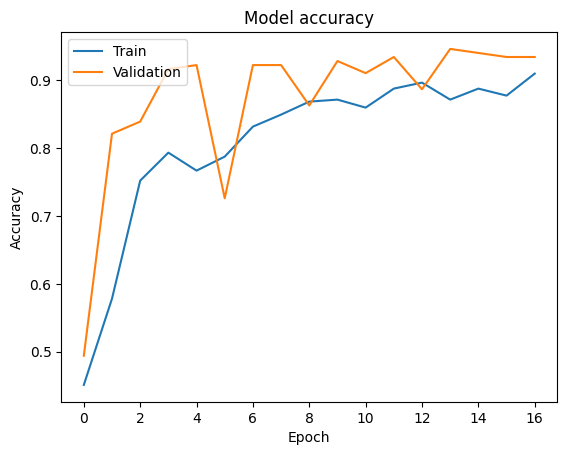

In [15]:
# Evaluate the model
validation_steps = 500
loss, accuracy = model.evaluate(validation_generator,steps = validation_steps)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

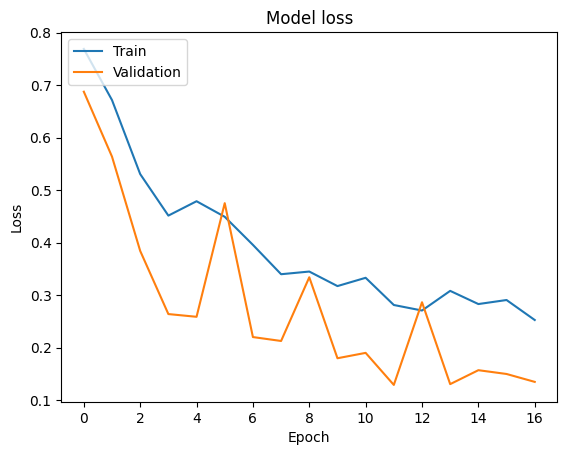

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [18]:
model.save('motors_vs_trucks.h5')



from tensorflow.keras.models import load_model
model = load_model('motors_vs_trucks.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    print(prediction)
    if prediction < 0.5:

        print("It's a car")
    else:
        print("It's a truck")

In [21]:
pred_car = predict_image('/content/car.jpg')
pred_truck = predict_image('/content/truck.jpg')

1/1 [==============================] - 1s 933ms/step
[[0.00260842]]
It's a car
1/1 [==============================] - 0s 33ms/step
[[0.99988055]]
It's a truck
